In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
correlation_matrix = np.array([
    [1.00, 0.50, 0.30, 0.60, 0.40, 0.30, 0.40, 0.30],
    [0.50, 1.00, 0.30, 0.60, 0.30, 0.20, 0.60, 0.30],
    [0.30, 0.30, 1.00, 0.60, 0.50, 0.40, 0.50, 0.50],
    [0.60, 0.60, 0.60, 1.00, 0.30, 0.70, 0.60, 0.30],
    [0.40, 0.30, 0.50, 0.30, 1.00, 0.50, 0.50, 0.30],
    [0.30, 0.20, 0.40, 0.70, 0.50, 1.00, 0.60, 0.30],
    [0.40, 0.60, 0.50, 0.60, 0.50, 0.60, 1.00, 0.60],
    [0.30, 0.30, 0.50, 0.30, 0.30, 0.30, 0.60, 1.00]
])

volatilities = np.array([0.2, 0.22, 0.25, 0.18, 0.45, 0.8, 0.35, 0.405])

In [3]:
cov_matrix = np.diag(volatilities) @ correlation_matrix @ np.diag(volatilities)
cov_matrix

array([[0.04    , 0.022   , 0.015   , 0.0216  , 0.036   , 0.048   ,
        0.028   , 0.0243  ],
       [0.022   , 0.0484  , 0.0165  , 0.02376 , 0.0297  , 0.0352  ,
        0.0462  , 0.02673 ],
       [0.015   , 0.0165  , 0.0625  , 0.027   , 0.05625 , 0.08    ,
        0.04375 , 0.050625],
       [0.0216  , 0.02376 , 0.027   , 0.0324  , 0.0243  , 0.1008  ,
        0.0378  , 0.02187 ],
       [0.036   , 0.0297  , 0.05625 , 0.0243  , 0.2025  , 0.18    ,
        0.07875 , 0.054675],
       [0.048   , 0.0352  , 0.08    , 0.1008  , 0.18    , 0.64    ,
        0.168   , 0.0972  ],
       [0.028   , 0.0462  , 0.04375 , 0.0378  , 0.07875 , 0.168   ,
        0.1225  , 0.08505 ],
       [0.0243  , 0.02673 , 0.050625, 0.02187 , 0.054675, 0.0972  ,
        0.08505 , 0.164025]])

In [4]:
benchmark_weights = np.array([0.095, 0.155, 0.055, 0.085, 0.1, 0.25, 0.17, 0.09])

In [5]:
benchmark_volatility = np.sqrt(benchmark_weights @ cov_matrix @ benchmark_weights)
benchmark_volatility

0.32626318594043063

In [6]:
carbon_intensity = np.array([80, 200, 390, 800, 60, 120, 135, 580])
benchmark_carbon_intensity = benchmark_weights @ carbon_intensity
benchmark_carbon_intensity

239.2

In [7]:
carbon_momentum = np.array([-0.05, -0.075, -0.015, -0.02, 0.08, -0.04, -0.07, 0.02])
benchmark_carbon_momentum = benchmark_weights @ carbon_momentum
benchmark_carbon_momentum

-0.031

In [8]:
green_intensity = np.array([0.05, 0.805, 0.15, 0, 0.02, 0, 0.6, 0.2])
benchmark_green_intensity = benchmark_weights @ green_intensity
benchmark_green_intensity

0.259775

In [9]:
esg_score = np.array([-2, 2.5, 1.5, 2, -1, -0.5, -0.5, 0.5])
benchmark_esg_score = benchmark_weights @ esg_score
benchmark_esg_score

0.185

In [10]:
x1, x2 = np.array([1, 0, 1, 1, 0, 0, 0, 1]), np.array([0, 1, 0, 0, 1, 1, 1, 0])

In [11]:
sector1, sector2 = benchmark_weights * x1, benchmark_weights * x2
sector1_exposition, sector2_exposition = np.sum(sector1), np.sum(sector2)
sector1_exposition, sector2_exposition

(0.325, 0.675)

In [12]:
sector1, sector2 = sector1 / np.sum(sector1), sector2 / np.sum(sector2)
sector1, sector2

(array([0.29230769, 0.        , 0.16923077, 0.26153846, 0.        ,
        0.        , 0.        , 0.27692308]),
 array([0.        , 0.22962963, 0.        , 0.        , 0.14814815,
        0.37037037, 0.25185185, 0.        ]))

In [13]:
carbon_intensity_sector1 = sector1 @ carbon_intensity
carbon_intensity_sector2 = sector2 @ carbon_intensity

carbon_intensity_sector1, carbon_intensity_sector2

(459.23076923076917, 133.25925925925924)

In [14]:
carbon_momentum_sector1 = sector1 @ carbon_momentum
carbon_momentum_sector2 = sector2 @ carbon_momentum

carbon_momentum_sector1, carbon_momentum_sector2

(-0.016846153846153848, -0.037814814814814815)

In [15]:
green_intensity_sector1 = sector1 @ green_intensity
green_intensity_sector2 = sector2 @ green_intensity

green_intensity_sector1, green_intensity_sector2

(0.09538461538461537, 0.3389259259259259)

In [16]:
esg_score_sector1 = sector1 @ esg_score
esg_score_sector2 = sector2 @ esg_score

esg_score_sector1, esg_score_sector2

(0.3307692307692307, 0.11481481481481473)

In [17]:
times = [0, 1, 2, 5, 10]

n = 8
x = cp.Variable(n)

te_over_time = []
ci_over_time = []
cm_over_time = []
gi_over_time = []
rr_over_time = []
s1_over_time = []
s2_over_time = []

for t in times:
    constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= (1 - 0.3) * ((1 - 0.07) ** t) * benchmark_carbon_intensity]
    objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value
    
    tracking_error_volatility_x = np.sqrt((x_opt - benchmark_weights) @ cov_matrix @ (x_opt - benchmark_weights))
    carbon_intensity_x = x_opt @ carbon_intensity
    carbon_momentum_x = x_opt @ carbon_momentum
    green_intensity_x = x_opt @ green_intensity
    reduction_rate_x = 1 - (carbon_intensity_x / benchmark_carbon_intensity)
    sector1_exposition_x, sector2_exposition_x = x_opt @ x1, x_opt @ x2

    te_over_time.append(tracking_error_volatility_x)
    ci_over_time.append(carbon_intensity_x)
    cm_over_time.append(carbon_momentum_x)
    gi_over_time.append(green_intensity_x)
    rr_over_time.append(reduction_rate_x)
    s1_over_time.append(sector1_exposition_x)
    s2_over_time.append(sector2_exposition_x)

    print(f"Portfolio: {x_opt}")
    print(f"Tracking error volatility: {tracking_error_volatility_x:.8f}")
    print(f"Carbon intensity: {carbon_intensity_x:.8f}")
    print(f"Carbon momentum: {carbon_momentum_x:.8f}")
    print(f"Green intensity: {green_intensity_x:.8f}")
    print(f"Reduction rate: {reduction_rate_x:.8f}")
    print(f"Sector 1 exposure: {sector1_exposition_x:.8f}")
    print(f"Sector 2 exposure: {sector2_exposition_x:.8f}")
    print('\n')

Portfolio: [1.66208836e-01 1.62817418e-01 6.45433445e-02 1.46878663e-21
 9.20632178e-02 2.57678603e-01 1.99812803e-01 5.68757783e-02]
Tracking error volatility: 0.01332595
Carbon intensity: 167.44000000
Carbon momentum: -0.03728137
Green intensity: 0.28216407
Reduction rate: 0.30000000
Sector 1 exposure: 0.28762796
Sector 2 exposure: 0.71237204


Portfolio: [1.86814060e-01 1.49652794e-01 5.19058628e-02 9.29989078e-22
 9.55816992e-02 2.55457592e-01 2.17821614e-01 4.27663775e-02]
Tracking error volatility: 0.01956098
Carbon intensity: 155.71920000
Carbon momentum: -0.03830720
Green intensity: 0.27875496
Reduction rate: 0.34900000
Sector 1 exposure: 0.28148630
Sector 2 exposure: 0.71851370


Portfolio: [2.05976919e-01 1.37409694e-01 4.01530049e-02 4.28955912e-22
 9.88538869e-02 2.53392052e-01 2.34569809e-01 2.96446348e-02]
Tracking error volatility: 0.02549621
Carbon intensity: 144.81885600
Carbon momentum: -0.03926123
Green intensity: 0.27558449
Reduction rate: 0.39457000
Sector 1 exposu

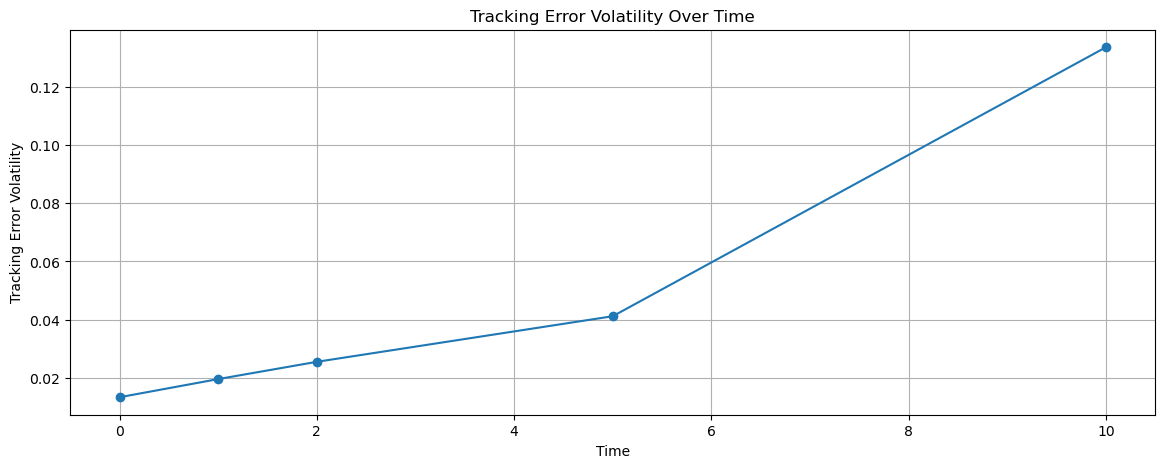

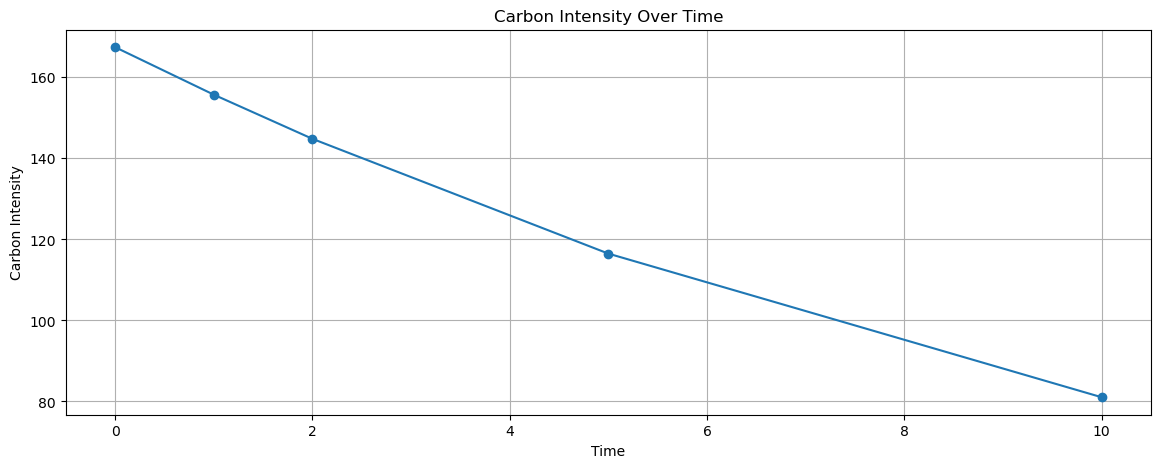

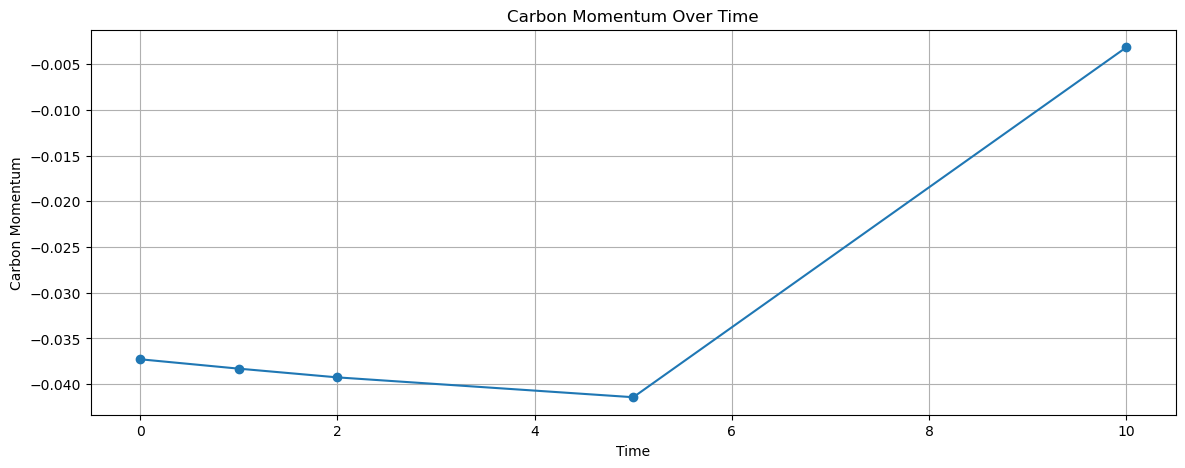

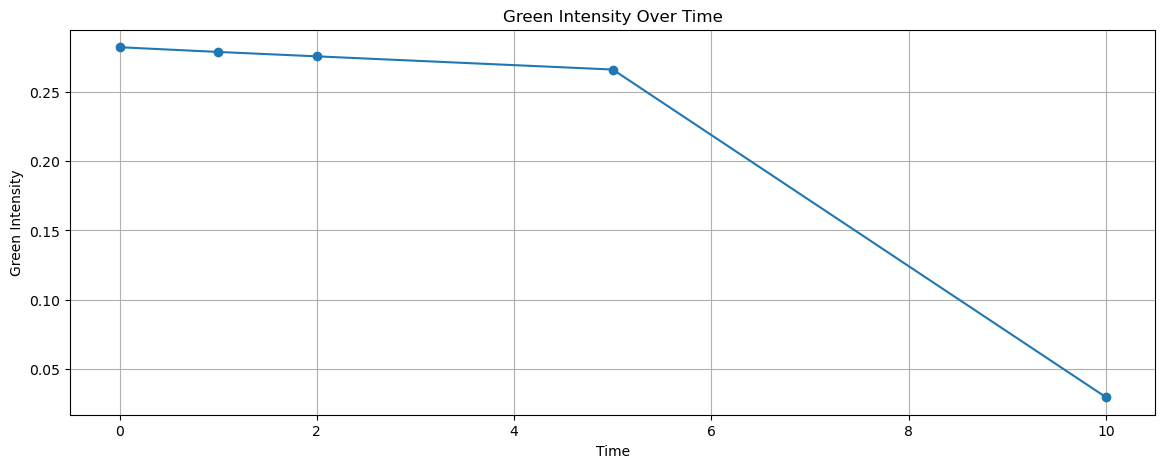

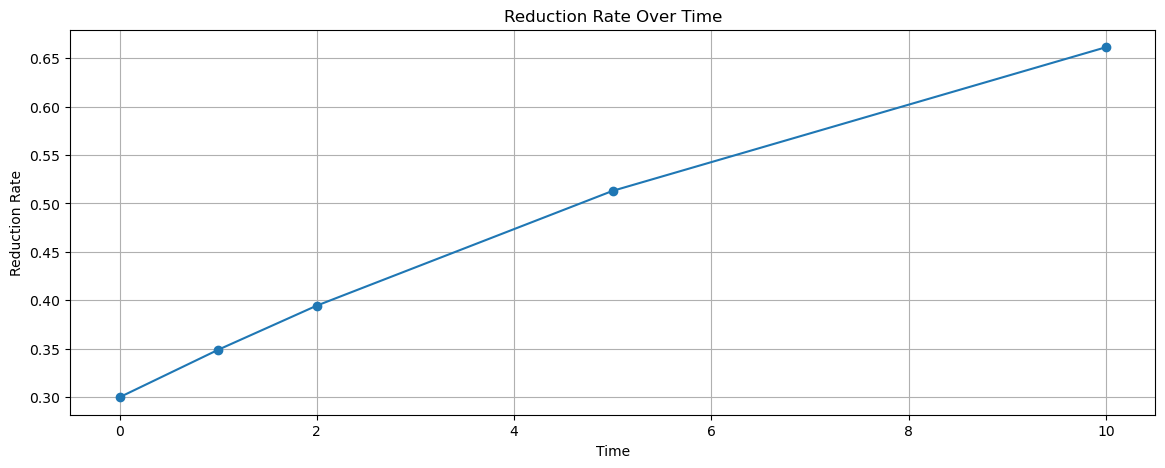

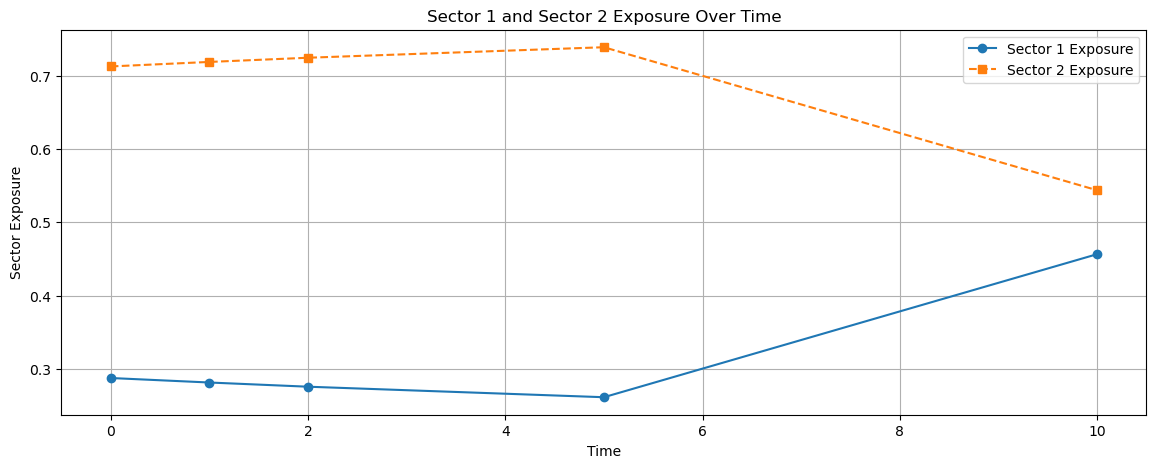

In [18]:
metrics = {
    "Tracking Error Volatility": te_over_time,
    "Carbon Intensity": ci_over_time,
    "Carbon Momentum": cm_over_time,
    "Green Intensity": gi_over_time,
    "Reduction Rate": rr_over_time
}

for metric, values in metrics.items():
    plt.figure(figsize=(14, 5))
    plt.plot(times, values, marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.title(f"{metric} Over Time")
    plt.grid(True)
    plt.show()

plt.figure(figsize=(14, 5))
plt.plot(times, s1_over_time, marker='o', linestyle='-', label="Sector 1 Exposure")
plt.plot(times, s2_over_time, marker='s', linestyle='--', label="Sector 2 Exposure")
plt.xlabel("Time")
plt.ylabel("Sector Exposure")
plt.title("Sector 1 and Sector 2 Exposure Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
times = [0, 1, 2, 5, 10]

n = 8
x = cp.Variable(n)

for t in times:
    constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= (1 - 0.3) * ((1 - 0.07) ** t) * benchmark_carbon_intensity, x @ x1 == sector1_exposition, x @ x2 == sector2_exposition]
    objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value
    
    tracking_error_volatility = np.sqrt((x_opt - benchmark_weights) @ cov_matrix @ (x_opt - benchmark_weights))
    carbon_intensity_x = x_opt @ carbon_intensity
    carbon_momentum_x = x_opt @ carbon_momentum
    green_intensity_x = x_opt @ green_intensity
    reduction_rate_x = 1 - (carbon_intensity_x / benchmark_carbon_intensity)

    print(f"Portfolio: {x_opt}")
    print(f"Tracking error volatility: {tracking_error_volatility:.8f}")
    print(f"Carbon intensity: {carbon_intensity_x:.8f}")
    print(f"Carbon momentum: {carbon_momentum_x:.8f}")
    print(f"Green intensity: {green_intensity_x:.8f}")
    print(f"Reduction rate: {reduction_rate_x:.8f}")
    print('\n')

Portfolio: [1.92832479e-01 1.33373709e-01 7.44680159e-02 9.66877927e-22
 8.58930161e-02 2.56476815e-01 1.99256460e-01 5.76995048e-02]
Tracking error volatility: 0.01481947
Carbon intensity: 167.44000000
Carbon momentum: -0.03694327
Green intensity: 0.26098930
Reduction rate: 0.30000000


Portfolio: [2.17812988e-01 1.15370356e-01 6.34615379e-02 4.44419798e-22
 8.83974970e-02 2.54058304e-01 2.17173843e-01 4.37254739e-02]
Tracking error volatility: 0.02096710
Carbon intensity: 155.71920000
Carbon momentum: -0.03791354
Green intensity: 0.25410037
Reduction rate: 0.34900000


Portfolio: [ 2.41044862e-01  9.86272379e-02  5.32255134e-02 -4.14181090e-23
  9.07266642e-02  2.51809089e-01  2.33837009e-01  3.07296251e-02]
Tracking error volatility: 0.02688841
Carbon intensity: 144.81885600
Carbon momentum: -0.03881590
Green intensity: 0.24769366
Reduction rate: 0.39457000


Portfolio: [ 3.03049958e-01  5.51361728e-02  2.19500425e-02  3.59189285e-22
  9.78135997e-02  2.46085591e-01  2.75964637e-01 

In [20]:
n = 8
x = cp.Variable(n)

constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= (1 - 0.3) * benchmark_carbon_intensity]
objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))

prob = cp.Problem(objective, constraints)
prob.solve()

x_opt = x.value

tracking_error_volatility_x = np.sqrt((x_opt - benchmark_weights) @ cov_matrix @ (x_opt - benchmark_weights))
carbon_intensity_x = x_opt @ carbon_intensity
carbon_momentum_x = x_opt @ carbon_momentum
green_intensity_x = x_opt @ green_intensity
esg_score_x = x_opt @ esg_score
sector1_exposition_x, sector2_exposition_x  = x_opt @ x1, x_opt @ x2

print(f"Portfolio: {x_opt}")
print(f"Tracking error volatility: {tracking_error_volatility_x:.8f}")
print(f"Carbon intensity: {carbon_intensity_x:.8f}")
print(f"Carbon momentum: {carbon_momentum_x:.8f}")
print(f"Green intensity: {green_intensity_x:.8f}")
print(f"ESG score: {esg_score_x}")
print(f"Sector 1 allocation: {sector1_exposition_x:.8f}")
print(f"Sector 2 allocation: {sector2_exposition_x:.8f}")

Portfolio: [1.66208836e-01 1.62817418e-01 6.45433445e-02 1.46878663e-21
 9.20632178e-02 2.57678603e-01 1.99812803e-01 5.68757783e-02]
Tracking error volatility: 0.01332595
Carbon intensity: 167.44000000
Carbon momentum: -0.03728137
Green intensity: 0.28216407
ESG score: -0.12093014196571558
Sector 1 allocation: 0.28762796
Sector 2 allocation: 0.71237204


In [21]:
n = 8
x = cp.Variable(n)

constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= (1 - 0.3) * benchmark_carbon_intensity, x @ green_intensity >= (1 + 0.5) * benchmark_green_intensity]
objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))

prob = cp.Problem(objective, constraints)
prob.solve()

x_opt = x.value

tracking_error_volatility_x = np.sqrt((x_opt - benchmark_weights) @ cov_matrix @ (x_opt - benchmark_weights))
carbon_intensity_x = x_opt @ carbon_intensity
carbon_momentum_x = x_opt @ carbon_momentum
green_intensity_x = x_opt @ green_intensity
esg_score_x = x_opt @ esg_score
sector1_exposition_x, sector2_exposition_x  = x_opt @ x1, x_opt @ x2

print(f"Portfolio: {x_opt}")
print(f"Tracking error volatility: {tracking_error_volatility_x:.8f}")
print(f"Carbon intensity: {carbon_intensity_x:.8f}")
print(f"Carbon momentum: {carbon_momentum_x:.8f}")
print(f"Green intensity: {green_intensity_x:.8f}")
print(f"ESG score: {esg_score_x:.8f}")
print(f"Sector 1 allocation: {sector1_exposition_x:.8f}")
print(f"Sector 2 allocation: {sector2_exposition_x:.8f}")

Portfolio: [6.38490597e-02 2.98197389e-01 3.20066975e-02 7.42927201e-21
 8.74671997e-02 2.57160005e-01 2.19017177e-01 4.23024724e-02]
Tracking error volatility: 0.03211064
Carbon intensity: 167.44000000
Carbon momentum: -0.04381153
Green intensity: 0.38966250
ESG score: 0.36140084
Sector 1 allocation: 0.13815823
Sector 2 allocation: 0.86184177


In [22]:
n = 8
x = cp.Variable(n)

constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= (1 - 0.3) * benchmark_carbon_intensity, x @ green_intensity >= (1 + 0.5) * benchmark_green_intensity, x @ carbon_momentum <= (1 + 0.5) * benchmark_carbon_momentum]
objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))

prob = cp.Problem(objective, constraints)
prob.solve()

x_opt = x.value

tracking_error_volatility_x = np.sqrt((x_opt - benchmark_weights) @ cov_matrix @ (x_opt - benchmark_weights))
carbon_intensity_x = x_opt @ carbon_intensity
carbon_momentum_x = x_opt @ carbon_momentum
green_intensity_x = x_opt @ green_intensity
esg_score_x = x_opt @ esg_score
sector1_exposition_x, sector2_exposition_x  = x_opt @ x1, x_opt @ x2

print(f"Portfolio: {x_opt}")
print(f"Tracking error volatility: {tracking_error_volatility_x:.8f}")
print(f"Carbon intensity: {carbon_intensity_x:.8f}")
print(f"Carbon momentum: {carbon_momentum_x:.8f}")
print(f"Green intensity: {green_intensity_x:.8f}")
print(f"ESG score: {esg_score_x:.8f}")
print(f"Sector 1 allocation: {sector1_exposition_x:.8f}")
print(f"Sector 2 allocation: {sector2_exposition_x:.8f}")

Portfolio: [7.63328542e-02 2.90848779e-01 4.18144437e-02 6.80165351e-21
 6.73595300e-02 2.59496693e-01 2.28159232e-01 3.59884681e-02]
Tracking error volatility: 0.03289451
Carbon intensity: 167.44000000
Carbon momentum: -0.04650000
Green intensity: 0.38966250
ESG score: 0.34398465
Sector 1 allocation: 0.15413577
Sector 2 allocation: 0.84586423


In [23]:
n = 8
x = cp.Variable(n)

constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= (1 - 0.3) * benchmark_carbon_intensity, x @ green_intensity >= (1 + 0.5) * benchmark_green_intensity, x @ carbon_momentum <= (1 + 0.5) * benchmark_carbon_momentum, x @ esg_score >= benchmark_esg_score + 0.5]
objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))

prob = cp.Problem(objective, constraints)
prob.solve()

x_opt = x.value

tracking_error_volatility_x = np.sqrt((x_opt - benchmark_weights) @ cov_matrix @ (x_opt - benchmark_weights))
carbon_intensity_x = x_opt @ carbon_intensity
carbon_momentum_x = x_opt @ carbon_momentum
green_intensity_x = x_opt @ green_intensity
esg_score_x = x_opt @ esg_score
sector1_exposition_x, sector2_exposition_x  = x_opt @ x1, x_opt @ x2

print(f"Portfolio: {x_opt}")
print(f"Tracking error volatility: {tracking_error_volatility_x:.8f}")
print(f"Carbon intensity: {carbon_intensity_x:.8f}")
print(f"Carbon momentum: {carbon_momentum_x:.8f}")
print(f"Green intensity: {green_intensity_x:.8f}")
print(f"ESG score: {esg_score_x:.8f}")
print(f"Sector 1 allocation: {sector1_exposition_x:.8f}")
print(f"Sector 2 allocation: {sector2_exposition_x:.8f}")

Portfolio: [ 2.64883276e-02  3.75566115e-01  6.64859328e-02 -8.16282438e-22
  8.26379521e-02  2.74044389e-01  1.68396026e-01  6.38125830e-03]
Tracking error volatility: 0.04405601
Carbon intensity: 167.44000000
Carbon momentum: -0.04650000
Green intensity: 0.41759465
ESG score: 0.68500000
Sector 1 allocation: 0.09935552
Sector 2 allocation: 0.90064448


In [24]:
n = 8
x = cp.Variable(n)

for R in np.arange(0, 1, 0.01):
    constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= (1 - R) * benchmark_carbon_intensity, x @ green_intensity >= (1 + 0.5) * benchmark_green_intensity, x @ carbon_momentum <= (1 + 0.5) * benchmark_carbon_momentum, x @ esg_score >= benchmark_esg_score + 0.5]
    objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value
    
    if x_opt is None:
        R0 = R
        break

In [25]:
n = 8
x = cp.Variable(n)

for R in np.arange(R0 - 0.1, R0 + 0.1, 0.0001):
    constraints = [x >= 0, cp.sum(x) == 1, x @ carbon_intensity <= (1 - R) * benchmark_carbon_intensity, x @ green_intensity >= (1 + 0.5) * benchmark_green_intensity, x @ carbon_momentum <= (1 + 0.5) * benchmark_carbon_momentum, x @ esg_score >= benchmark_esg_score + 0.5]
    objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    x_opt = x.value
    
    if x_opt is None:
        print(f"There is no solution for R equal to: {R}")
        break

There is no solution for R equal to: 0.3927999999999898


In [26]:
n = 8
x = cp.Variable(n)

constraints = [x >= 0, cp.sum(x) == 1, cp.multiply(x, x1) @ carbon_intensity <= (1 - 0.3) * carbon_intensity_sector1 * cp.sum(cp.multiply(x, x1)), cp.multiply(x, x2) @ carbon_intensity <= (1 - 0.5) * carbon_intensity_sector2 * cp.sum(cp.multiply(x, x2))]
objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))

prob = cp.Problem(objective, constraints)
prob.solve()

x_opt_b = x.value

tracking_error_volatility_x_b = np.sqrt((x_opt_b - benchmark_weights) @ cov_matrix @ (x_opt_b - benchmark_weights))
carbon_intensity_x_b = x_opt_b @ carbon_intensity
carbon_momentum_x_b = x_opt_b @ carbon_momentum
green_intensity_x_b = x_opt_b @ green_intensity
esg_score_x_b = x_opt_b @ esg_score
sector1_exposition_x_b, sector2_exposition_x_b  = x_opt_b @ x1, x_opt_b @ x2

print(f"Portfolio: {x_opt_b}")
print(f"Tracking error volatility: {tracking_error_volatility_x_b:.8f}")
print(f"Carbon intensity: {carbon_intensity_x_b:.8f}")
print(f"Carbon momentum: {carbon_momentum_x_b:.8f}")
print(f"Green intensity: {green_intensity_x_b:.8f}")
print(f"ESG score: {esg_score_x_b:.8f}")
print(f"Sector 1 allocation: {sector1_exposition_x_b:.8f}")
print(f"Sector 2 allocation: {sector2_exposition_x_b:.8f}")

Portfolio: [3.35175789e-01 3.17025820e-20 3.95937315e-02 9.20721026e-02
 3.56725340e-01 4.43121692e-02 6.91051191e-19 1.32120868e-01]
Tracking error volatility: 0.17332890
Carbon intensity: 219.26438456
Carbon momentum: 0.01021382
Green intensity: 0.05625653
ESG score: -0.73963777
Sector 1 allocation: 0.59896249
Sector 2 allocation: 0.40103751


In [27]:
n = 8
x = cp.Variable(n)

constraints = [x >= 0, cp.sum(x) == 1, cp.multiply(x, x1) @ carbon_intensity <= (1 - 0.3) * carbon_intensity_sector1 * cp.sum(cp.multiply(x, x1)), cp.multiply(x, x2) @ carbon_intensity <= (1 - 0.5) * carbon_intensity_sector2 * cp.sum(cp.multiply(x, x2)), x @ x1 == sector1_exposition, x @ x2 == sector2_exposition]
objective = cp.Minimize(cp.quad_form(x - benchmark_weights, cov_matrix))

prob = cp.Problem(objective, constraints)
prob.solve()

x_opt_c = x.value

tracking_error_volatility_x_c = np.sqrt((x_opt_c - benchmark_weights) @ cov_matrix @ (x_opt_c - benchmark_weights))
carbon_intensity_x_c = x_opt_c @ carbon_intensity
carbon_momentum_x_c = x_opt_c @ carbon_momentum
green_intensity_x_c = x_opt_c @ green_intensity
esg_score_x_c = x_opt_c @ esg_score
sector1_exposition_x_c, sector2_exposition_x_c  = x_opt_c @ x1, x_opt_c @ x2

print(f"Portfolio: {x_opt_c}")
print(f"Tracking error volatility: {tracking_error_volatility_x_c:.8f}")
print(f"Carbon intensity: {carbon_intensity_x_c:.8f}")
print(f"Carbon momentum: {carbon_momentum_x_c:.8f}")
print(f"Green intensity: {green_intensity_x_c:.8f}")
print(f"ESG score: {esg_score_x_c:.8f}")
print(f"Sector 1 allocation: {sector1_exposition_x_c:.8f}")
print(f"Sector 2 allocation: {sector2_exposition_x_c:.8f}")

Portfolio: [ 1.89816608e-01  9.92013647e-21 -2.69650675e-19  4.94695634e-02
  6.00416667e-01  7.45833333e-02  1.54041305e-19  8.57138288e-02]
Tracking error volatility: 0.20315765
Carbon intensity: 149.45000000
Carbon momentum: 0.03628405
Green intensity: 0.03864193
ESG score: -0.87554551
Sector 1 allocation: 0.32500000
Sector 2 allocation: 0.67500000


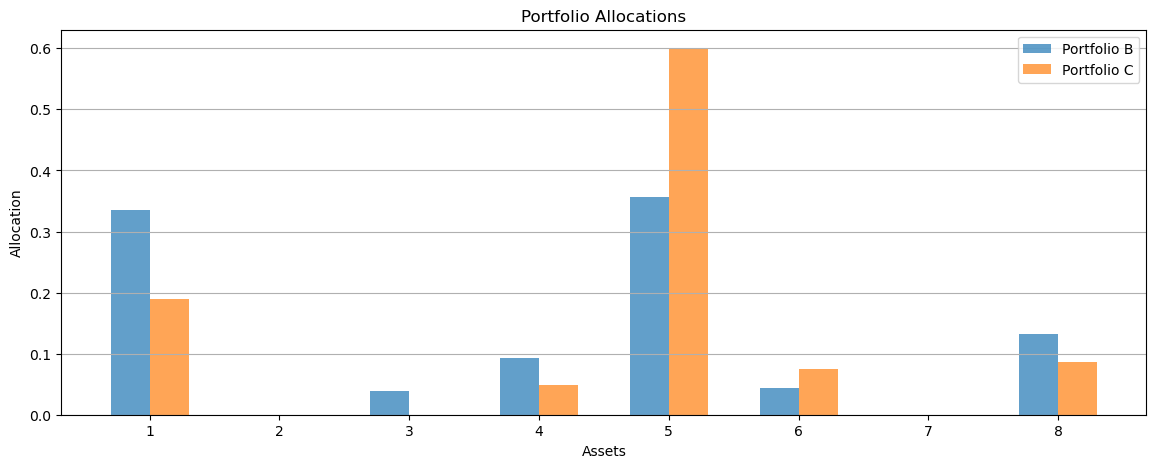

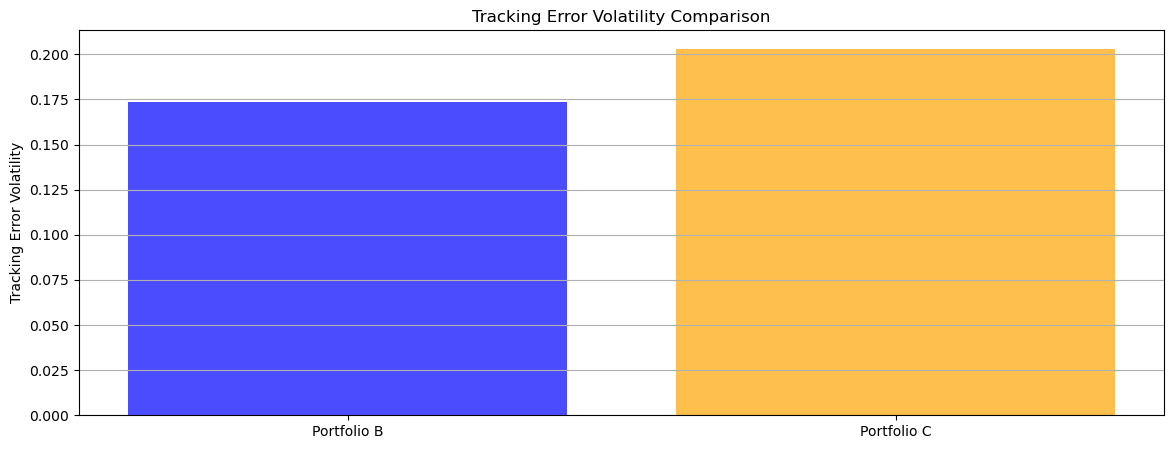

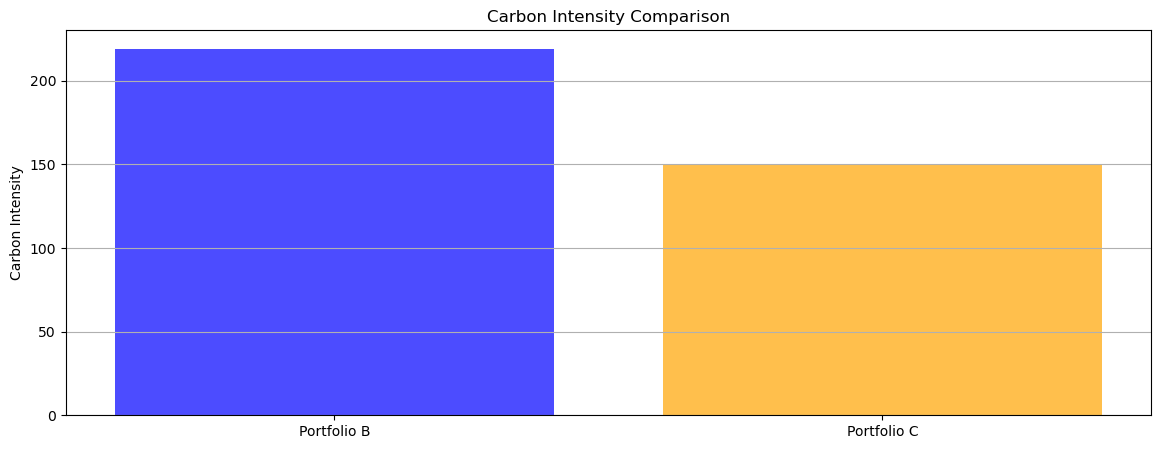

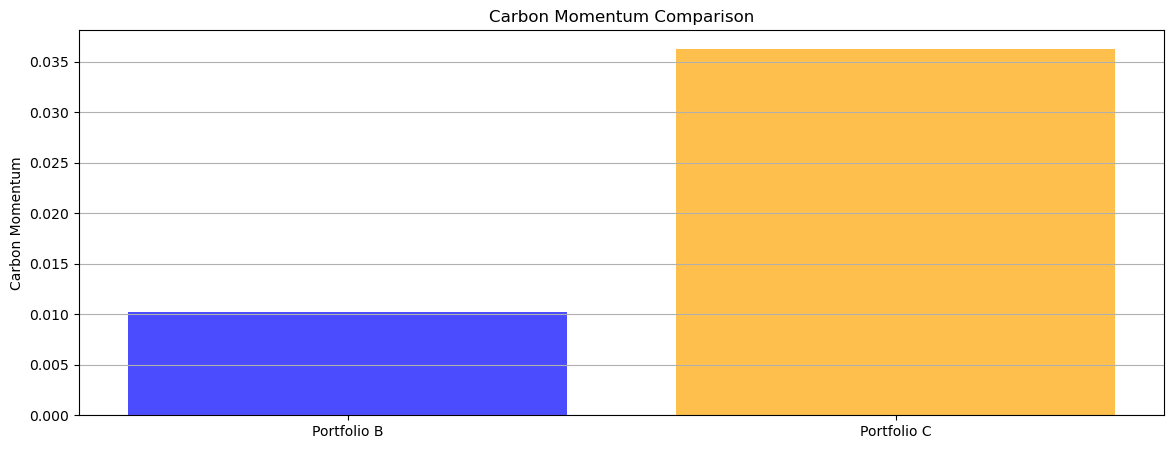

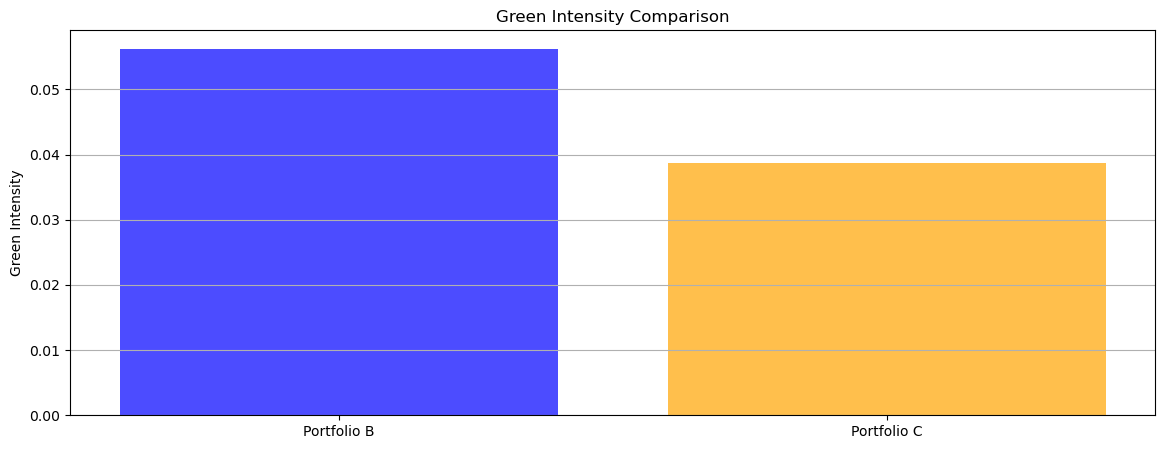

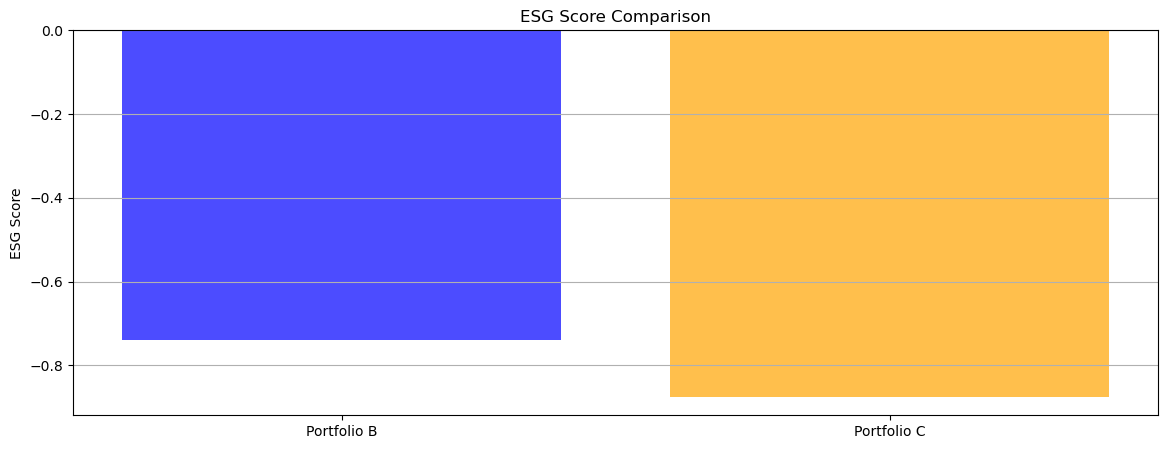

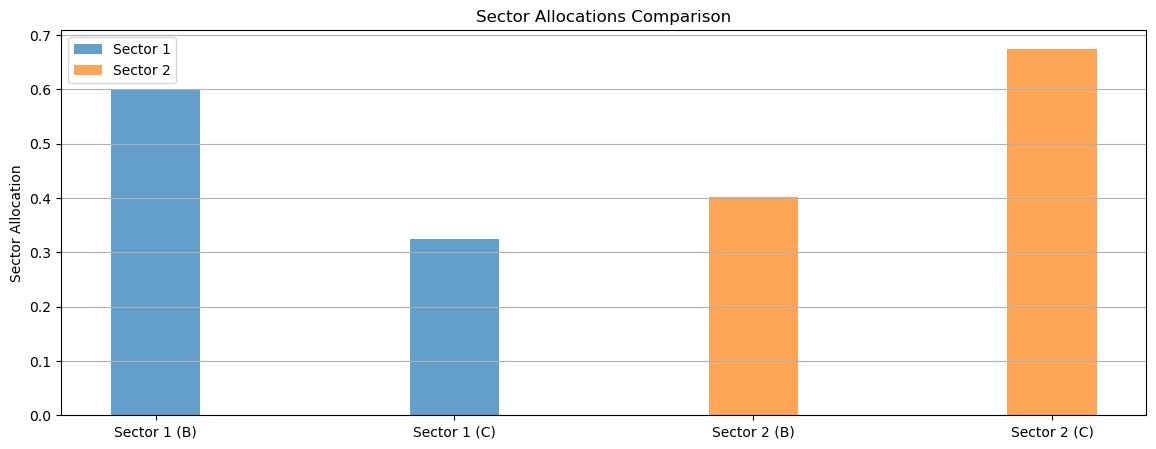

In [28]:
assets = np.arange(1, 9)

plt.figure(figsize=(14, 5))
width = 0.3
plt.bar(assets - width/2, x_opt_b, width=width, label="Portfolio B", alpha=0.7)
plt.bar(assets + width/2, x_opt_c, width=width, label="Portfolio C", alpha=0.7)
plt.xlabel("Assets")
plt.ylabel("Allocation")
plt.title("Portfolio Allocations")
plt.xticks(assets)
plt.legend()
plt.grid(axis='y')
plt.show()

metrics = {
    "Tracking Error Volatility": (tracking_error_volatility_x_b, tracking_error_volatility_x_c),
    "Carbon Intensity": (carbon_intensity_x_b, carbon_intensity_x_c),
    "Carbon Momentum": (carbon_momentum_x_b, carbon_momentum_x_c),
    "Green Intensity": (green_intensity_x_b, green_intensity_x_c),
    "ESG Score": (esg_score_x_b, esg_score_x_c),
}

for metric, values in metrics.items():
    plt.figure(figsize=(14, 5))
    plt.bar(["Portfolio B", "Portfolio C"], values, color=['blue', 'orange'], alpha=0.7)
    plt.ylabel(metric)
    plt.title(metric + " Comparison")
    plt.grid(axis='y')
    plt.show()

plt.figure(figsize=(14, 5))
width = 0.3
plt.bar(["Sector 1 (B)", "Sector 1 (C)"], [sector1_exposition_x_b, sector1_exposition_x_c], width=width, label="Sector 1", alpha=0.7)
plt.bar(["Sector 2 (B)", "Sector 2 (C)"], [sector2_exposition_x_b, sector2_exposition_x_c], width=width, label="Sector 2", alpha=0.7)
plt.ylabel("Sector Allocation")
plt.title("Sector Allocations Comparison")
plt.grid(axis='y')
plt.legend()
plt.show()